In [1]:
%pip install scikit-image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import Dataset
import numpy as np
from MatrixVectorizer import MatrixVectorizer
import random
import optuna
import numpy as np
from adabound import AdaBound
import pandas as pd
from torch.nn import Module, ModuleList, Linear, ReLU, Sequential, Sigmoid
import torch.nn.functional as F

import numpy as np
from MatrixVectorizer import MatrixVectorizer
from sklearn.model_selection import KFold
import networkx as nx

from model import AGSRNet 
from train import train, test
import matplotlib.pyplot as plt
import seaborn as sns
from comprehensive_metrics import comprehensive_eval, plot_fold_metrics
from sklearn.metrics import mean_absolute_error

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. GPU.")
        return torch.device("cuda")
    else:
        print("CUDA not available. CPU.")
        return torch.device("cpu")

random_seed = 69 # nice
set_seeds(random_seed)
device = get_device()

print("Cell done loading")


Note: you may need to restart the kernel to use updated packages.


/vol/bitbucket/au123/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available. GPU.
Cell done loading


In [2]:
import torch
import numpy as np
import random

def add_random_edges(adj_matrix, num_edges):
    """
    Randomly adds a given number of edges to the adjacency matrix of the graph.

    Args:
    adj_matrix (torch.Tensor): The adjacency matrix of the graph.
    num_edges (int): The number of edges to add.

    Returns:
    torch.Tensor: The augmented adjacency matrix.
    """
    num_nodes = adj_matrix.shape[0]
    new_edges = 0
    new_adj_matrix = adj_matrix.clone()

    while new_edges < num_edges:
        i = random.randint(0, num_nodes - 1)
        j = random.randint(0, num_nodes - 1)

        if i != j and new_adj_matrix[i, j] == 0:
            new_adj_matrix[i, j] = new_adj_matrix[j, i] = 1
            new_edges += 1

    return new_adj_matrix

def drop_random_edges(adj_matrix, num_edges):
    """
    Randomly removes a given number of edges from the adjacency matrix of the graph.

    Args:
    adj_matrix (torch.Tensor): The adjacency matrix of the graph.
    num_edges (int): The number of edges to remove.

    Returns:
    torch.Tensor: The augmented adjacency matrix.
    """
    edges = [(i, j) for i in range(adj_matrix.shape[0]) for j in range(i) if adj_matrix[i, j] > 0]
    edges_to_drop = random.sample(edges, num_edges)

    new_adj_matrix = adj_matrix.clone()
    for (i, j) in edges_to_drop:
        new_adj_matrix[i, j] = new_adj_matrix[j, i] = 0

    return new_adj_matrix

def shuffle_node_features(node_features):
    """
    Randomly shuffles the node features of the graph.

    Args:
    node_features (torch.Tensor): The node features.

    Returns:
    torch.Tensor: The node features with shuffled feature positions.
    """
    num_features = node_features.shape[1]
    perm = torch.randperm(num_features)
    new_features = node_features[:, perm]

    return new_features

def augment_data(adj_matrices, num_augmentations):
    """
    Apply a series of augmentations to the adjacency matrices.

    Args:
    adj_matrices (list of torch.Tensor): A list of adjacency matrices.
    num_augmentations (int): Number of augmentations to apply.

    Returns:
    list of torch.Tensor: List of augmented adjacency matrices.
    """
    augmented_adjs = []

    for adj in adj_matrices:
        for _ in range(num_augmentations):
            # Randomly add or remove edges
            num_edges_to_change = random.randint(1, 20)
            if random.random() > 0.5:
                new_adj = add_random_edges(adj, num_edges_to_change)
            else:
                new_adj = drop_random_edges(adj, num_edges_to_change)

            augmented_adjs.append(new_adj)

    return augmented_adjs


In [3]:
class SymmetricMatrixVectorizer:
    """Handles vectorization and devectorization of symmetric matrices."""
    def __init__(self):
        self.vectorizer = MatrixVectorizer()

    def vectorize(self, matrix):
        """Vectorize a symmetric matrix"""
        matrix_np = matrix.numpy()  # Convert to NumPy array for vectorization
        return self.vectorizer.vectorize(matrix_np)

    def devectorize(self, vector, size):
        """Devectorize into a symmetric matrix"""
        if isinstance(vector, torch.Tensor):
            vector = vector.numpy()  # Ensure the vector is a NumPy array
        matrix_np = self.vectorizer.anti_vectorize(vector, size)
        return torch.tensor(matrix_np, dtype=torch.float)

def load_data(file_path):
    """Load dataset from a CSV file."""
    return pd.read_csv(file_path).values

def tensor_conversion(data, dimension, vectorizer):
    """Convert list of matrices to a PyTorch tensor."""
    tensor_list = [vectorizer.devectorize(x, dimension) for x in data]
    tensor_data = torch.stack(tensor_list)  # Use torch.stack to create a 3D tensor from the list
    return tensor_data


def normalisation(adj):
    # Add self-loops to the adjacency matrix
    adj_with_self_loops = adj + torch.eye(adj.shape[0], device=adj.device)
    
    # Calculate the degree matrix (with added self-loops), and then compute its inverse square root
    D_hat_inv_sqrt = torch.diag(1.0 / torch.sqrt(torch.sum(adj_with_self_loops, axis=0)))
    
    # Apply normalization
    adj_norm = D_hat_inv_sqrt @ adj_with_self_loops @ D_hat_inv_sqrt
    
    return adj_norm


# Initialize vectorizer
vectorizer = SymmetricMatrixVectorizer()

# Load the data
lr_train = load_data('data/lr_train.csv')
hr_train = load_data('data/hr_train.csv')
lr_test = load_data('data/lr_test.csv')

# Convert datasets to tensors- not used currently since vctoisation happens later
lr_train_devectorized = tensor_conversion(lr_train, 160, vectorizer)
hr_train_devectorized = tensor_conversion(hr_train, 268, vectorizer)
lr_test_devectorized = tensor_conversion(lr_test, 160, vectorizer)

print("Cell done loading")


Cell done loading


In [4]:
class Data(Dataset):
    def __init__(self, features, labels=None, device='cuda'):
        """
        Initializes the dataset.

        Args:
            features (Tensor): The features of the dataset.
            labels (Tensor, optional): The labels of the dataset. Defaults to None.
            device (str, optional): The device to which the tensors will be transferred. Defaults to 'cpu'.
        """
        self.features = features.clone().detach().to(device).float()
        self.labels = None if labels is None else labels.clone().detach().to(device).float()

    def __len__(self):
        """Returns the number of items in the dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """
        Returns the feature and label at the specified index.

        Args:
            idx (int): The index of the item.

        Returns:
            tuple: A tuple containing the feature and label at the specified index.
        """
        label = self.labels[idx] if self.labels is not None else None
        return self.features[idx], label

def adabound_optimizer(params, lr=0.001, final_lr=0.1):
    """Create and return an AdaBound optimizer."""
    return AdaBound(params, lr=lr, final_lr=final_lr)


def prepare_datasets(X_train, y_train, X_val, y_val):
    """Prepare training and validation datasets."""
    if X_val is None:
        return {'train': Data(X_train, y_train)}
    
    return {
        'train': Data(X_train, y_train),
        'val': Data(X_val, y_val)
    }

In [5]:
class AGSR:
    def __init__(self):
        self.epochs = 200
        self.lr = 0.0001
        # self.lr = 0.001
        self.lmbda = 0.1
        self.lr_dim = 160
        self.hr_dim = 320
        self.hidden_dim = 320
        self.padding = 26
        self.mean_dense = 0.
        self.std_dense = 0.01
        self.mean_gaussian = 0.
        self.std_gaussian = 0.1
        
        # Model setup
        kernel_sizes = [0.9, 0.7, 0.6, 0.5]
        self.model = AGSRNet(kernel_sizes, self)
        self.model_path = 'data/agsr_model.pth'  
        
    def save_model(self):
        """Save the model to the specified path."""
        torch.save(self.model.state_dict(), self.model_path)

    def load_model(self):
        """Load the model from the specified path."""
        self.model.load_state_dict(torch.load(self.model_path))

    def train(self, lr_vectors, hr_vectors):
        """Train the model and save it."""
        train(self.model, lr_vectors, hr_vectors, self)
        self.save_model()

    def predict(self, lr_vectors):
        """Load the model and predict high-resolution vectors from low-resolution inputs."""
        self.load_model()
        self.model.eval()
        with torch.no_grad():
            predicted_hr_vectors = test(self.model, lr_vectors, self)
        return predicted_hr_vectors


In [6]:
# Initialize AGSR model and KFold with parameterization
num_folds = 3  # Or another number of folds you want to use
agr_model = AGSR()
k_fold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=42)

low_resolution_images = np.array(lr_train)  
high_resolution_images = np.array(hr_train)  

# Store the fold results
fold_results = []

#check that the GAT is in there
print(agr_model.model)

# Perform cross-validation
for current_fold, (training_indices, testing_indices) in enumerate(k_fold_splitter.split(low_resolution_images), start=1):
    print(f"Fold {current_fold}: ")
    
    # Split the data into training and testing sets for this fold
    low_res_train, low_res_test = low_resolution_images[training_indices], low_resolution_images[testing_indices]
    high_res_train, high_res_test = high_resolution_images[training_indices], high_resolution_images[testing_indices]
    
    # Vectorize the training and testing data
    train_input_matrices = np.array([MatrixVectorizer.anti_vectorize(x, 160) for x in low_res_train])
    test_input_matrices = np.array([MatrixVectorizer.anti_vectorize(x, 160) for x in low_res_test])
    train_output_matrices = np.array([MatrixVectorizer.anti_vectorize(x, 268) for x in high_res_train])
    test_output_matrices = np.array([MatrixVectorizer.anti_vectorize(x, 268) for x in high_res_test])
                                     
    train_input_matrices = np.array(train_input_matrices)
    test_input_matrices = np.array(test_input_matrices)
    train_output_matrices = np.array(train_output_matrices)
    test_output_matrices = np.array(test_output_matrices)

    # Train the model
    fold_model = AGSR()
    fold_model.train(train_input_matrices, train_output_matrices)
    
    # Evaluate the model on the test set and log the results
    predicted_test_output_matrices = fold_model.predict(test_input_matrices)
    metrics = comprehensive_eval(test_output_matrices, predicted_test_output_matrices)
    fold_results.append(metrics)


AGSRNet(
  (layer): GSRLayer()
  (net): GraphUnet(
    (start_gcn): GCN(
      (proj): Linear(in_features=160, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (bottom_gcn): GCN(
      (proj): Linear(in_features=320, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (end_gcn): GCN(
      (proj): Linear(in_features=640, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
  )
  (gin1): GINLayer(
    (mlp): Sequential(
      (0): Linear(in_features=320, out_features=320, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=320, out_features=320, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
    )
  )
  (gin2): GINLayer(
    (mlp): Sequential(
      (0): Linear(in_features=320, out_features=320, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=320, out_features=320, bias=True)
      (4): R

KeyboardInterrupt: 

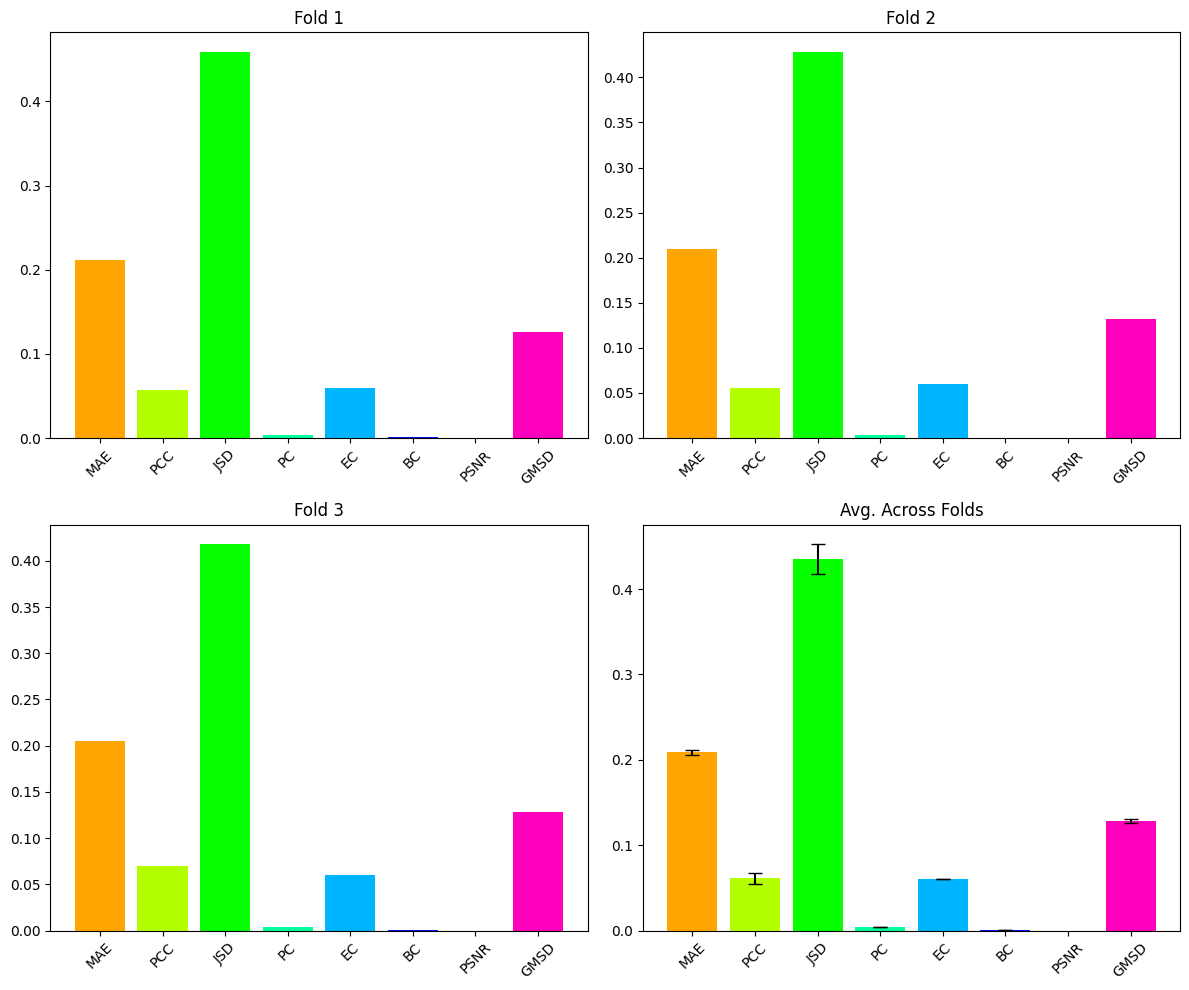

In [7]:
plot_fold_metrics(fold_results)

## Evaluate fitted model with additional metrics with entire train dataset

In [ ]:
def train_model_on_full_dataset(lr_train_data, hr_train_data):
    # Initialize AGSR model
    agr_model = AGSR()

    print(agr_model.model)
    # print(agr_model.lr)

    # Convert low and high resolution images from lists/arrays to numpy arrays
    low_resolution_images = np.array(lr_train_data)  
    high_resolution_images = np.array(hr_train_data)  

    # Vectorize the training data
    train_input_matrices = np.array([MatrixVectorizer.anti_vectorize(x, 160) for x in low_resolution_images])
    train_output_matrices = np.array([MatrixVectorizer.anti_vectorize(x, 268) for x in high_resolution_images])

    agr_model.train(train_input_matrices, train_output_matrices)

    return agr_model


trained_model = train_model_on_full_dataset(lr_train, hr_train)

torch.save(trained_model.state_dict(), 'agsr_model_full_dataset.pth')


AGSRNet(
  (layer): GSRLayer()
  (net): GraphUnet(
    (start_gcn): GCN(
      (proj): Linear(in_features=160, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (bottom_gcn): GCN(
      (proj): Linear(in_features=320, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (end_gcn): GCN(
      (proj): Linear(in_features=640, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
  )
  (gin1): GINLayer(
    (mlp): Sequential(
      (0): Linear(in_features=320, out_features=320, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=320, out_features=320, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
    )
  )
  (gin2): GINLayer(
    (mlp): Sequential(
      (0): Linear(in_features=320, out_features=320, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=320, out_features=320, bias=True)
      (4): R

In [8]:
# KAGGLE CODE FOR AGSR

import pandas as pd
import numpy as np

def data_preprocessing(data_path):
    """Load data and cleanse by replacing negative and NaN values with 0."""
    data = pd.read_csv(data_path)
    data = np.maximum(data, 0)  # Ensures all negative values are set to 0
    data = np.nan_to_num(data)  # Replaces NaNs with 0 and returns a numpy array
    return data

def vectorize_data(data):
    """Vectorize the data using a MatrixVectorizer and process it for prediction."""
    vectorized_data = [MatrixVectorizer.anti_vectorize(row, 160) for row in data]
    return np.array(vectorized_data)

def process_predictions(predictions):
    """Vectorize predictions, flatten the array, and prepare submission DataFrame."""
    vectorized_predictions = np.array([MatrixVectorizer.vectorize(pred) for pred in predictions])
    flattened_predictions = vectorized_predictions.flatten()
    predictions_for_csv = pd.DataFrame({
        'ID': np.arange(1, len(flattened_predictions) + 1),
        'Predicted': flattened_predictions
    })
    return predictions_for_csv

agr_model = trained_model

test_data_path = 'data/lr_test.csv'
preprocessed_data = data_preprocessing(test_data_path)
# need to vectorize for kaggle
vectorized_test_data = vectorize_data(preprocessed_data)

test_predictions_tmp = agr_model.predict(vectorized_test_data)
predictions_for_csv = process_predictions(test_predictions_tmp)

predictions_for_csv.to_csv('data/predictions.csv', index=False)
